Привиден анализ данных по выдачам кредитов и платежам: плановым и фактическим по состоянию на 08.12.2022. Анализ проведен посредством python (pandas, numpy, matlotlib, sqlite3, seaborn, tabulate) и SQL.
Вывод представлен в конце файла

In [6]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from tabulate import tabulate
import seaborn as sns

# Загрузка данных из CSV-файлов
orders_df = pd.read_csv('orders.csv')
payments_df = pd.read_csv('payments.csv')
plan_df = pd.read_csv('plan.csv')

# Проверям отображение первых нескольких строк каждого DataFrame
print("Orders:")
print(orders_df.head())

print("\nPayments:")
print(payments_df.head())

print("\nPlan:")
print(plan_df.head())

Orders:
    order_id               created_at                   put_at  \
0  400001732  2022-06-02 00:00:23.997  2022-06-02 20:18:00.180   
1  400005838  2022-06-02 00:10:22.997  2022-06-02 15:41:33.267   
2  400007915  2022-06-02 00:18:04.000  2022-06-05 19:17:38.547   
3  400008952  2022-06-02 00:22:07.000  2022-06-03 14:25:18.033   
4  400009027  2022-06-02 00:25:39.000  2022-06-02 00:40:40.320   

                 closed_at  issued_sum  
0  2022-10-17 11:52:22.190     13600.0  
1  2022-06-02 17:38:43.917     20000.0  
2  2022-06-21 21:55:51.877      5820.0  
3  2022-07-12 10:47:46.307      9000.0  
4  2022-06-22 14:15:07.423      5000.0  

Payments:
    order_id                  paid_at  paid_sum
0  400013633  2022-06-02 00:48:13.800    2500.0
1  400018480  2022-06-02 01:52:05.707    1070.0
2  400032001  2022-06-02 04:55:40.307    4200.0
3  400033195  2022-06-02 05:44:23.480    2850.0
4  400039407  2022-06-02 06:53:54.503   10100.0

Plan:
    order_id     plan_at  plan_sum_total
0 

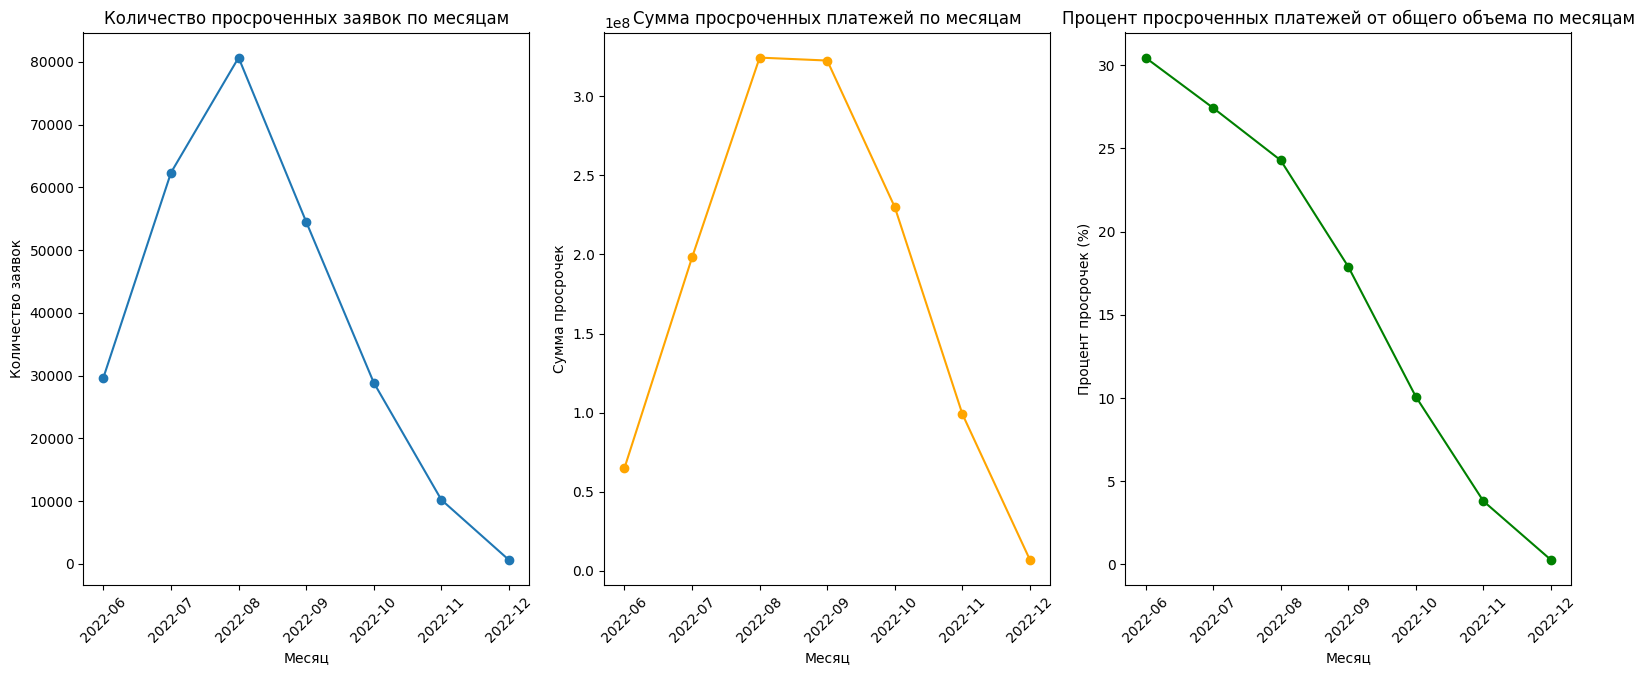

In [7]:
# Объединяем данные
combined_df = orders_df.merge(plan_df, on='order_id', how='left').merge(payments_df, on='order_id', how='left')

# Преобразуем даты в формат datetime
combined_df['plan_at'] = pd.to_datetime(combined_df['plan_at'])
combined_df['paid_at'] = pd.to_datetime(combined_df['paid_at'])
combined_df['put_at'] = pd.to_datetime(combined_df['put_at'])
combined_df['closed_at'] = pd.to_datetime(combined_df['closed_at'])

# Добавляем колонку, определяющую статус платежа
combined_df['overdue'] = combined_df.apply(
    lambda row: row['plan_sum_total'] - row['paid_sum'] if row['paid_at'] > row['plan_at'] else 0,
    axis=1
)

# Фильтруем только те заявки, которые имеют просроченные платежи
overdue_orders = combined_df[combined_df['overdue'] > 0]

# Анализируем динамику просрочки
# 1. Количество просроченных заявок по месяцам
overdue_counts = overdue_orders['plan_at'].dt.to_period('M').value_counts().sort_index()

# 2. Сумма просроченных платежей по месяцам
overdue_sums = overdue_orders.groupby(overdue_orders['plan_at'].dt.to_period('M'))['overdue'].sum().reindex(overdue_counts.index, fill_value=0)

# 3. Рассчитываем общие суммы планов по месяцам для определения процента просрочек
total_planned_sums = combined_df.groupby(combined_df['plan_at'].dt.to_period('M'))['plan_sum_total'].sum().reindex(overdue_counts.index, fill_value=0)

# 4. Рассчитываем процент просроченных платежей
percentage_overdue = np.divide(overdue_sums.values, total_planned_sums.values, out=np.zeros_like(overdue_sums.values), where=total_planned_sums.values != 0) * 100

plt.figure(figsize=(16, 7))

# График количества просроченных платежей
plt.subplot(1, 3, 1)
plt.plot(overdue_counts.index.astype(str), overdue_counts.values, marker='o')
plt.title('Количество просроченных заявок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заявок')
plt.xticks(rotation=45)

# График суммы просроченных платежей
plt.subplot(1, 3, 2)
plt.plot(overdue_sums.index.astype(str), overdue_sums.values, marker='o', color='orange')
plt.title('Сумма просроченных платежей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма просрочек')
plt.xticks(rotation=45)

# График процента просроченных платежей
plt.subplot(1, 3, 3)
plt.plot(overdue_sums.index.astype(str), percentage_overdue, marker='o', color='green')
plt.title('Процент просроченных платежей от общего объема по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Процент просрочек (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

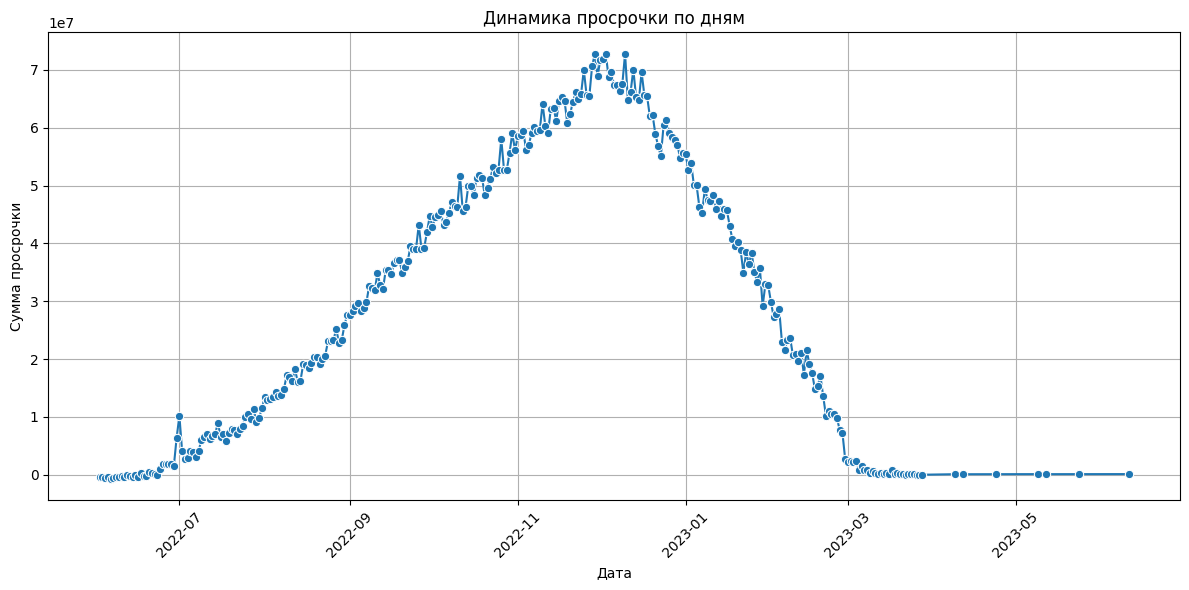

In [3]:
merged_df['paid_sum'] = merged_df['paid_sum'].fillna(0)
merged_df['late_payment'] = merged_df['plan_sum_total'] - merged_df['paid_sum']
merged_df['plan_at'] = pd.to_datetime(merged_df['plan_at'])
late_payment_trend = merged_df.groupby('plan_at').agg({'late_payment': 'sum'}).reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=late_payment_trend, x='plan_at', y='late_payment', marker='o')
plt.title('Динамика просрочки по дням')
plt.xlabel('Дата')
plt.ylabel('Сумма просрочки')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [61]:
# Создание таблицы результатов
results_df = pd.DataFrame({
    'Месяц': overdue_counts.index.astype(str),
    'Количество просроченных заявок': overdue_counts.values,
    'Сумма просроченных платежей': overdue_sums.values,
    'Процент просроченных платежей (%)': percentage_overdue
})

results_df.set_index('Месяц', inplace=True)
results_df['Сумма просроченных платежей'] = results_df['Сумма просроченных платежей'].apply(lambda x: f"{x:,.2f}")  # Форматируем сумму

# Устанавливаем стиль для таблицы
styled_results_df = results_df.style.set_table_attributes('style="border-collapse: collapse; width: 100%;"') \
                                     .set_properties(**{'border': '1px solid black', 'text-align': 'center'}) \
                                     .set_table_styles([{'selector': 'th', 
                                                         'props': [('border', '1px solid black')]},
                                                        {'selector': 'td', 
                                                         'props': [('border', '1px solid black')]}])

# Выводим таблицу
styled_results_df

,Количество просроченных заявок,Сумма просроченных платежей,Процент просроченных платежей (%)
Месяц,,,
2022-06,29695,"65,018,421.25",30.461526
2022-07,62348,"198,044,561.14",27.438612
2022-08,80666,"324,325,545.06",24.288669
2022-09,54510,"322,477,163.30",17.892600
2022-10,28880,"229,828,740.71",10.075913
2022-11,10217,"99,089,380.92",3.796994
2022-12,633,"6,926,872.62",0.262733


In [6]:
def to_datetime_with_errors(df, columns):
    for column in columns:
        df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

orders_df = to_datetime_with_errors(orders_df, ['created_at', 'put_at', 'closed_at'])
payments_df = to_datetime_with_errors(payments_df, ['paid_at'])
plan_df = to_datetime_with_errors(plan_df, ['plan_at'])


merged_df = payments_df.merge(plan_df, on='order_id', how='outer')

merged_df.dropna(subset=['paid_at', 'plan_at'], inplace=True)

merged_df['delay'] = (merged_df['paid_at'] - merged_df['plan_at']).dt.days

# Фильтруем только просроченные платежи (которые были оплачены после плановой даты)
delayed_payments = merged_df[merged_df['delay'] > 0]

# Находим максимальную просрочку
if not delayed_payments.empty:
    max_delay_row = delayed_payments.loc[delayed_payments['delay'].idxmax()]
    max_delay_order_id = max_delay_row['order_id']
    max_delay_days = max_delay_row['delay']
else:
    max_delay_order_id = None
    max_delay_days = 0

# Находим заявку с максимальной суммой платежа
max_payment_row = payments_df.loc[payments_df['paid_sum'].idxmax()]
max_order_payment_id = max_payment_row['order_id']
max_paid_sum = round(max_payment_row['paid_sum'], 2)

# Находим заявку с максимальной суммой выдачи
max_issue_row = orders_df.loc[orders_df['issued_sum'].idxmax()]
max_order_issue_id = max_issue_row['order_id']
max_issued_sum = round(max_issue_row['issued_sum'], 2)

# Создаем таблицу с результатами
results_df = pd.DataFrame({
    'Тип': ['Максимальная сумма фактического платежа', 'Максимальная сумма выдачи', 'Максимум просрочки (в днях)'],
    'Номер заявки': [max_order_payment_id, max_order_issue_id, max_delay_order_id],
    'Сумма': [max_paid_sum, max_issued_sum, max_delay_days]  # Просрочка в днях
})

# Применение форматирования к колонке 'Сумма'
results_df['Сумма'] = results_df['Сумма'].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

styled_results_df = results_df.style.set_table_attributes('style="border: 2px solid black; border-collapse: collapse;"') \
                                      .set_properties(**{'border': '2px solid black', 
                                                         'text-align': 'center'}) \
                                      .set_table_styles([{
                                          'selector': 'th', 
                                          'props': [('border', '2px solid black'),
                                                    ('background-color', '#f0f0f0'),
                                                    ('font-weight', 'bold'),
                                                    ('text-align', 'center')]
                                      },
                                      {
                                          'selector': 'td', 
                                          'props': [('border', '2px solid black')]
                                      }])

# Выводим таблицу
styled_results_df

,Тип,Номер заявки,Сумма
0,Максимальная сумма фактического платежа,487895263,49469.37
1,Максимальная сумма выдачи,400260014,28570.00
2,Максимум просрочки (в днях),406674411,183.00


Далее представлен код на SQL для выявления заявки с самой поздней датой фактического платежа с использованием sqlite3 в целях более детального исследования и демонстрации навыков работы с SQL 

In [8]:
# Временной соединение
conn = sqlite3.connect(':memory:')

# Загрузка данных в временные таблицы
orders_df.to_sql('orders', conn, index=False, if_exists='replace')
payments_df.to_sql('payments', conn, index=False, if_exists='replace')

# SQL запрос для получения order_id и paid_at из orders с самой поздней датой фактического платежа из payments
query = """
SELECT o.order_id, p.paid_at
FROM orders o
JOIN payments p ON o.order_id = p.order_id
WHERE p.paid_at = (SELECT MAX(paid_at) FROM payments)
"""

# Выполнение запроса
result_df = pd.read_sql_query(query, conn)

# Закрытие соединения
conn.close()

# Вывод результатов
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=False))


+------------+-------------------------+
|   order_id | paid_at                 |
|------------+-------------------------|
|  436374755 | 2022-12-08 13:28:23.703 |
+------------+-------------------------+


Код на SQL. Самая поздняя дата планового платежа 

In [17]:
# Создание соединения с временной базой данных
conn = sqlite3.connect(':memory:')

# Загрузка данных из plan.csv в временную таблицу
plan_df = pd.read_csv('plan.csv')
plan_df.to_sql('plan', conn, index=False, if_exists='replace')

# SQL запрос для получения order_id и самой поздней даты plan_at из таблицы plan
query = """
SELECT order_id, MAX(plan_at) as latest_plan_at
FROM plan 
GROUP BY order_id
ORDER BY latest_plan_at DESC
LIMIT 2
"""

# Выполнение запроса
result_df = pd.read_sql_query(query, conn)

# Закрытие соединения
conn.close()

# Вывод результатов
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=False))

+------------+------------------+
|   order_id | latest_plan_at   |
|------------+------------------|
|  479493884 | 2023-06-11       |
|  470408029 | 2023-06-11       |
+------------+------------------+


**Исходя из проведенного исследования (графиков и таблиц) можно сделать следующие выводы:**
1) С 06.2022 по 08.2022 г. наблюдался рост количества просроченных заявок. При этом пиком (когда кол-во просроченных заявок было максимальным) был 08.2022 г., количество таких заявок составило 80666. С 09.2022 по 12.2022 включительно наблюдалось снижение количества просроченных заявок.
2) С 06.2022 по 08.2022 г. наблюдался рост суммы просроченных платежей. При этом 08.2022 г. (пик) максимальная сумма 324,325,545. С 09.2022 г. по 12.2022 г. включительно наблюдалось снижение
3) Процент просроченных платежей от общего объёма по месяцам постепенно снижался с 06.2022 г. и достиг своего минимума в 12.2022 г.
4) За все время максимальная сумма фактического платежа равна 49469.37 (id заявки - 487895263)
5) За все время максимальная сумма выдачи составила 28570 (id заявки - 400260014)
6) Максимальный срок просрочки в днях составил 183 (id заявки - 406674411)
7) Самая поздняя дата фактического платежа 08.12.2022 (id заявки - 436374755)
8) Последняя дата планового платежа 06.11.2023 (id 479493884, 470408029)